## Código de modelos XGBoost y Random Forest para la identificación de galaxias barradas

In [ ]:
# _______________________________________________________________________________________________________________________________________________
# Esta primera sección únicamente se incluye para poder tomar la tabla de características de imagénes de galaxias con base en la última entrega.
# _______________________________________________________________________________________________________________________________________________

In [1]:
# Conexión con drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Tomamos como referencia el código previamente establecido para la identificación de características en las imagenes de galaxias.

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Función mejorada para extraer características
def extract_advanced_features(image_path):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Verificar si la imagen se cargó correctamente
    if image is None:
        print(f"Error al cargar la imagen: {image_path}")
        return [0] * 20

    # Tamaño de la imagen
    height, width = image.shape
    area = height * width

    # Histograma de intensidad
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_mean = np.mean(hist)
    hist_median = np.median(hist)
    hist_std = np.std(hist)
    hist_var = np.var(hist)
    hist_entropy = entropy(hist.flatten())

    # Detección de bordes (Canny)
    edges = cv2.Canny(image, 100, 200)
    edge_count = np.sum(edges > 0)
    edge_density = edge_count / area

    # Textura Alternativa (Usando OpenCV directamente)
    glcm = cv2.calcHist([image], [0], None, [256], [0, 256])
    contrast = np.var(glcm)
    homogeneity = 1 - (np.sum(glcm) / (np.max(glcm) + 1e-10))
    asm = np.sum(glcm ** 2) / (height * width)

    # Hu Moments (Geometría)
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Circularidad y Aspect Ratio
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        area_contour = cv2.contourArea(largest_contour)
        aspect_ratio = width / height
        circularity = 4 * np.pi * (area_contour / (perimeter ** 2)) if perimeter > 0 else 0
    else:
        aspect_ratio = 0
        circularity = 0

    # Transformada de Fourier (Frecuencias)
    f_transform = np.fft.fft2(image)
    f_magnitude = np.abs(f_transform).mean()

    return [
        hist_mean, hist_median, hist_std, hist_var, hist_entropy,
        edge_count, edge_density,
        contrast, homogeneity, asm,
        hu_moments[0], hu_moments[1], hu_moments[2], hu_moments[3],
        hu_moments[4], hu_moments[5], hu_moments[6],
        aspect_ratio, circularity, f_magnitude
    ]

# Definiendo la ruta de las imágenes preprocesadas
processed_images_path = '/content/drive/MyDrive/Proyecto integrador/Insumos/Insumo'

# Cargando el dataset
dataset_path = '/content/drive/MyDrive/Proyecto integrador/dataset.csv'
df = pd.read_csv(dataset_path)

# Verificando y creando la columna 'has_bar'
df['has_bar'] = df['Bars'].apply(lambda x: 1 if x > 0 else 0)
df = df[df['Bars'] >= 0].reset_index(drop=True)

# Aplicando la extracción de características avanzadas
features = []

print("Extrayendo características avanzadas de las imágenes... Esto puede tardar unos minutos.")
for index, row in df.iterrows():
    image_path = os.path.join(processed_images_path, f"{row['name']}.png")
    features.append(extract_advanced_features(image_path))

# Agregando las nuevas características al dataframe
feature_columns = [
    'hist_mean', 'hist_median', 'hist_std', 'hist_var', 'hist_entropy',
    'edge_count', 'edge_density',
    'contrast', 'homogeneity', 'asm',
    'hu_1', 'hu_2', 'hu_3', 'hu_4', 'hu_5', 'hu_6', 'hu_7',
    'aspect_ratio', 'circularity', 'fourier_magnitude'
]
df[feature_columns] = pd.DataFrame(features)
print("Características avanzadas extraídas y agregadas al dataset.")

df.head()

Extrayendo características avanzadas de las imágenes... Esto puede tardar unos minutos.
Características avanzadas extraídas y agregadas al dataset.


,name,objra,objdec,Bars,has_bar,hist_mean,hist_median,hist_std,hist_var,hist_entropy,...,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,hu_7,aspect_ratio,circularity,fourier_magnitude
0,manga-10001-12701,133.371091,57.598425,0.0,0,625.0,490.0,613.608826,3.765158e+05,5.166482,...,0.001184,1.233985e-10,3.883725e-13,1.171087e-14,-7.894761e-28,1.274452e-19,-2.204764e-29,1.0,0.057901,17466.264206
1,manga-10001-12702,133.685670,57.480250,0.5,1,625.0,545.5,727.687073,5.295284e+05,4.996509,...,0.001520,3.297506e-11,4.532184e-13,2.571305e-14,2.774526e-27,-1.032025e-19,8.326139e-29,1.0,0.005260,12954.238276
2,manga-10001-12703,136.017160,57.092329,0.5,1,625.0,570.0,557.202087,3.104742e+05,5.181705,...,0.001354,6.792828e-11,6.853430e-14,1.670761e-14,2.967164e-28,-2.771251e-20,-4.812402e-28,1.0,0.030359,14500.640344
3,manga-10001-12704,133.989967,57.677968,0.0,0,625.0,468.5,960.793335,9.231239e+05,5.043430,...,0.001183,3.696471e-09,4.034299e-12,1.045332e-12,-3.769360e-25,-6.010706e-17,-2.113317e-24,1.0,0.015946,17859.988258
4,manga-10001-12705,136.751375,57.451437,0.0,0,625.0,436.0,1062.663574,1.129254e+06,4.831638,...,0.001368,1.821301e-10,5.220031e-13,8.374627e-13,-1.112730e-25,-1.115275e-17,5.424172e-25,1.0,0.017590,15672.179262


In [ ]:
# _______________________________________________________________________________________________________________________________________________
# Fin de la sección de características de imagénes de galaxias.
# _______________________________________________________________________________________________________________________________________________

# >>> MODELO **XGBoost** <<<
Una opción para poder predecir la identificación de galaxias barradas es el modelo XGBoost como un algoritmo de boosting de árboles los cuales tienen un buen manejo de variables numéricas derivadas de imágenes como: histogramas, momentos, bordes, etc. y la clasificación binaria como nuestro caso: Barrada vs no barrada.

In [3]:
# Importación de librerías necesarias

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Definición de variables predictoras (X) y variable objetivo (y)

X = df[feature_columns].values
y = df['has_bar'].values  # Etiqueta binaria: 1 si tiene barra, 0 si no

In [5]:
# División de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Entrenamiento de modelo

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    eval_metric='auc',
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [7]:
# Realización de predicciones

y_pred = xgb_model.predict(X_test)

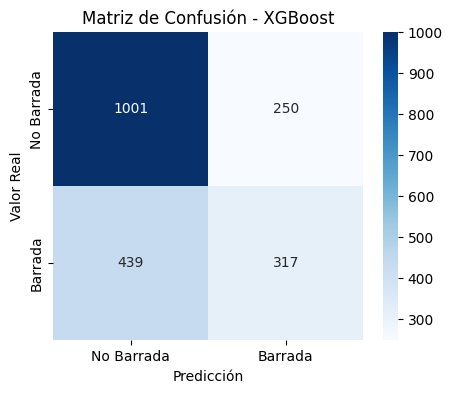

In [8]:
# Matriz de confusión

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Barrada", "Barrada"], yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [9]:
# Reporte de clasificación

print("Reporte de Clasificación - XGBoost")
print(classification_report(y_test, y_pred, target_names=["No Barrada", "Barrada"]))

Reporte de Clasificación - XGBoost
              precision    recall  f1-score   support

  No Barrada       0.70      0.80      0.74      1251
     Barrada       0.56      0.42      0.48       756

    accuracy                           0.66      2007
   macro avg       0.63      0.61      0.61      2007
weighted avg       0.64      0.66      0.64      2007



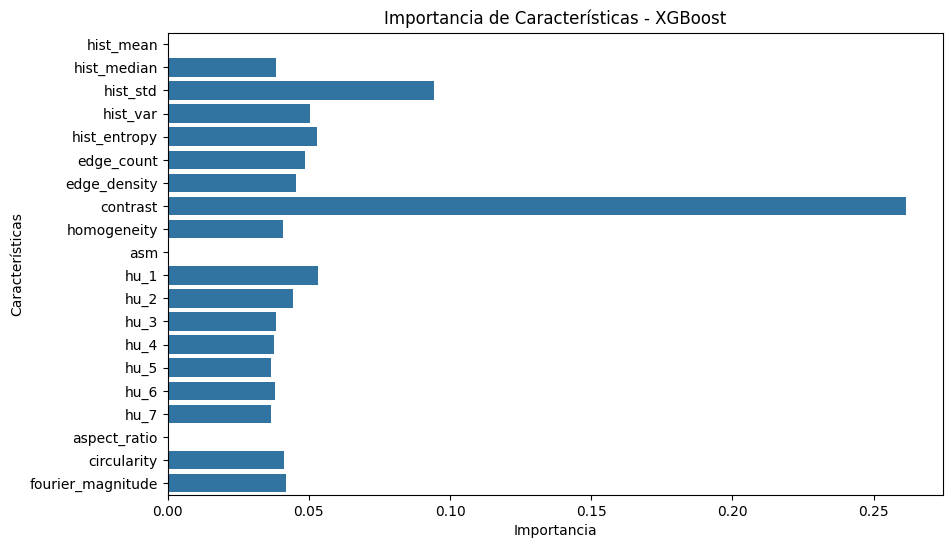

In [10]:
# Visualización de importancia de características

importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_columns)
plt.title("Importancia de Características - XGBoost")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

# Conclusiones de modelo **XGBoost:**

##### Con base en los resultados obtenidos del modelo, podemos concluir:
##### 1. Valores verdaderos positivos **(TP) "Galaxia Barrada" detectada correctamente.**
##### Valores verdaderos positivos **(TN) "Galaxia No Barrada" detectada correctamente.**
##### 2. El modelo tiene una precisión aceptable en clases negativas, pero comete **más errores en identificar correctamente galaxias barradas**
##### 3. Se obtiene un **Recall bajo**, muchos falsos negativos, lo que nos indica que **el modelo falla en capturar muchas galaxias barradas verdaderas.**
-- Aunque el modelo logra una precisión aceptable, la efectividad para detectar galaxias barradas es limitada. --


# >>> MODELO **Random Forest** <<<

Los modelos Random Forest son ensambles de árboles de decisión entrenados con bagging, los cuales capturan relaciones no lineales y se adaptan bien a data frames con muchas variables numéricas, como es nuestro caso de 20 características.

In [11]:
# Definición de librerías

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Creación del clasificador y entrenamiento de modelo Random Forest

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [13]:
# Definición de prediccones

y_pred_rf = rf_model.predict(X_test)

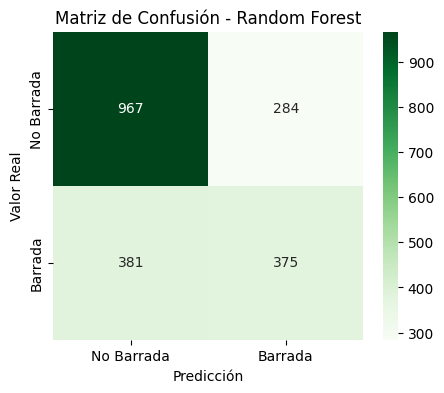

In [14]:
# Evaluación de modelo

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Barrada", "Barrada"],
            yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [15]:
# Reporte de clasificación

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred_rf, target_names=["No Barrada", "Barrada"]))

Accuracy: 0.6686596910812157

Reporte de Clasificación:

              precision    recall  f1-score   support

  No Barrada       0.72      0.77      0.74      1251
     Barrada       0.57      0.50      0.53       756

    accuracy                           0.67      2007
   macro avg       0.64      0.63      0.64      2007
weighted avg       0.66      0.67      0.66      2007



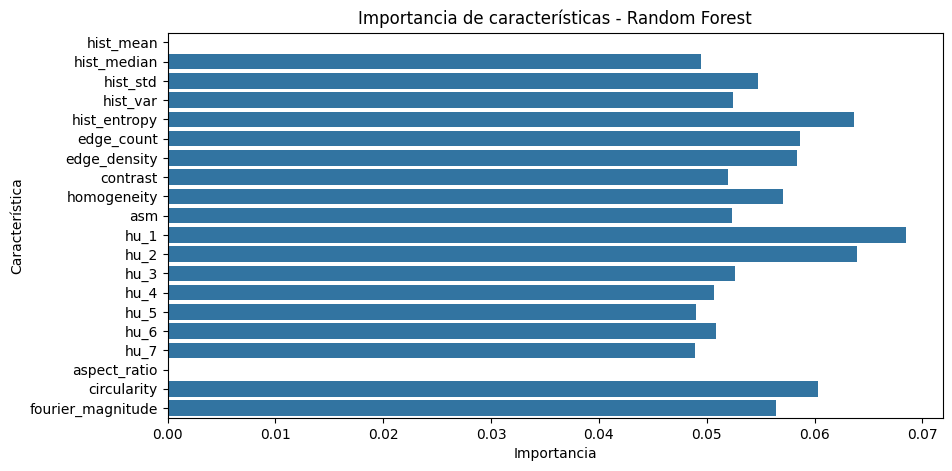

In [16]:
# Importancia de características

importances = rf_model.feature_importances_
feature_names = feature_columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Importancia de características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# Conclusiones de modelo **Random Forest:**
##### Con base en los resultados obtenidos del modelo, podemos concluir:
##### 1.El modelo **reconoce más galaxias Barradas** en comparación con XGBoost, **pero reduce ligeramente la detección de No Barradas.**
##### 2. El **Recall obtenido es ligeramente bajo**, similar al modelo XGBoost.
-- El modelo Random Forest ofrece un mejor resultado de detección de galaxias Barradas. --

# Comparativa de **XGBoost vs Random Forest**

-- Metricas para clase Barrada  XGBoots  vs Random Forest
* **Precisión** |  ~ 0.57  |  ~ 0.57  |
* **Recall**    |  ~ 0.42  |  ~ 0.50  |
* **F1-score**  |  ~ 0.48  |  ~ 0.53  |
* **Accuracy**  |  ~ 0.66  |  ~ 0.66  |

 - **Random Forest ofrece ligeramente un mejor rendimiento general para identificar Galaxias Barradas**
 - **XGBoost es más preciso en clase negativa, pero menos efectivo en la clase Barrada**